In [1]:
import numpy as np
import pandas as pd
import numpy.random as rn
import matplotlib.pyplot as plt
import csv
import random
import scipy.integrate as it

In [2]:
fname="Erskine_IL24_Edited.dat"
f=pd.read_csv(fname,sep='\s+',skiprows=[i for i in range(1,29030,203)])

In [3]:
dtemp=np.array(f[['B']])
dobs=list()
for data in dtemp:
    dobs.append(data[0])

In [4]:
dobs=np.array(dobs)

In [5]:
d_list=list()
for i in range(0,len(dobs),202):
    d_list.append(dobs[i:i+202])

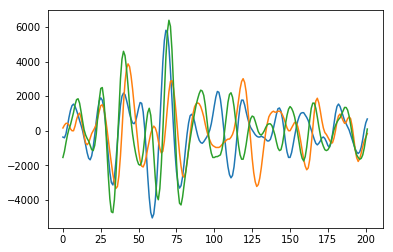

In [6]:
ind=0
plt.plot(range(len(d_list[ind])),d_list[ind])
plt.plot(range(len(d_list[ind])),d_list[ind+50])
plt.plot(range(len(d_list[ind])),d_list[ind+140])

In [7]:
fname1="Scaled_Wavelet.csv"
f1=pd.read_csv(fname1)
wav_ini=np.array(f1[['A']])

In [8]:
print(wav_ini[0])

[-89.1123]


In [9]:
wav=np.array([i[0] for i in wav_ini])

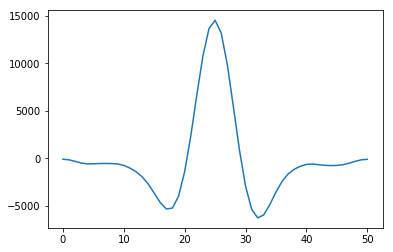

In [10]:
plt.plot (range(len(wav)), wav)

#def ricker(f=25, length=0.08, dt=0.004):
def ricker(f=25, length=0.120, dt=0.004):
    t0 = np.arange(-length/2, (length+dt)/2, dt)
    g = (1.0 - 2.0*(np.pi**2)*(f**2)*(t0**2)) * np.exp(-(np.pi**2)*(f**2)*(t0**2))
    return t0, list(g)

t0,w=ricker()

def I_get(r:list(),I0):
    I=list()
    I.append(I0)
    for i in range(len(r)):
        if((1-r[i])!=0.0):
            I.append(I[i]*((1+r[i])/(1-r[i])))
        else:
            I.append(1.0)
    return I

def r_get(I:list()):
    r=list()
    for i in range(len(I)-1):
        if((I[i+1]+I[i])!=0.0):
            r.append((I[i+1]-I[i])/(I[i+1]+I[i]))
        else:
            r.append(0.0)
    return r

In [11]:
class Operator(object):
    

    def __init__(self, wavelet):
         
        self.wavelet= wavelet
         
        
    def forward(self, r):
         
        return np.convolve(r, self.wavelet, mode ='same') 
                           
    def adjoint(self, r):
         
        return np.correlate(r, self.wavelet, mode ='same') 

In [12]:
F= Operator(wav)

In [13]:
t=np.array(list(range(798,1200,2)))

def wedge_I(minVal=300,maxVal=500,time=t):    
    I=list()
    for i in time:
        if i<minVal or i>maxVal:
            I.append(4500.0)
        else:
            I.append(5500.0)
    return np.array(I)

I=wedge_I()

r=np.array(r_get(I))
 

s=F.forward(r)

def wedge(minVal=300,maxVal=500,sampleSize=4):
    I_list=list()
    r_list=list()
    s_list=list()
    while maxVal>=minVal:
        I=wedge_I(minVal,maxVal)
        r=r_get(I)
        s=F.forward(r)
        I_list.append(I)
        r_list.append(r)
        s_list.append(s)
        maxVal=maxVal-sampleSize
    return I_list,r_list,s_list

I_list,r_list,s_list=wedge()

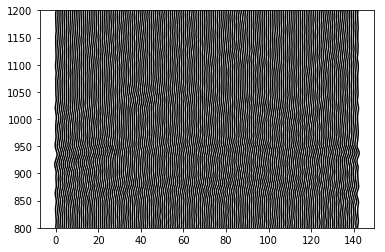

In [14]:
fig,ax = plt.subplots()
y_res=np.array(d_list)/10.e5
offsets=[i for i in range(len(d_list))]
t=np.array(list(range(798,1202,2)))
for i in range(len(offsets)):
    x=offsets[i]+100*y_res[i]
    #plt.figure(figsize=(15,3))
    ax.plot(x,t,'k')
    #ax.fill_betweenx(y,offsets[i],x,where=(x>offsets[i]),color='k')
ax.set_ylim(1200,800)
plt.show()

In [15]:
n=5

In [16]:
r_pred=list()
r_pred_integ=list()
d_pred=list()
t=np.array(list(range(798,1202,2)))
for k in range(len(d_list)):   
    d=d_list[k]
    #r_obs=r_list[k]
    m_est = np.zeros_like(d)
    #print(len(m_est))
    r = d - F.forward(m_est)
    #print(m_est)
    s = np.zeros_like(d)
    beta = 0

    for i in range(n):
        g = F.adjoint(r)
        if i != 0:
            beta = np.dot(g, g) / gamma
        gamma = np.dot(g, g)
        s = g + beta * s
        deltar = F.forward(s)
        alpha = np.dot(g, g) / np.dot(deltar, deltar)
        m_est = m_est + alpha * s
        r = r - alpha * deltar
    d_pred.append(F.forward(m_est))
    r_pred.append(m_est)
    #r_pred_integ.append(it.cumtrapz(m_est, t, initial=798.0))
    r_pred_integ.append(it.cumtrapz(m_est, t))

print(len(r_pred_integ[0]))
print(len(t))

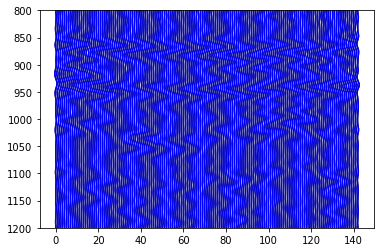

In [17]:
fig,ax = plt.subplots()
y_res_obs=np.array(d_list)/1.e5
y_res_pred=np.array(d_pred)/1.e5
offsets=[i for i in range(len(d_list))]
t=np.array(list(range(798,1202,2)))
for i in range(len(offsets)):
    x_obs=offsets[i]+10*y_res_obs[i]
    x_pred=offsets[i]+10*y_res_pred[i]
    ax.plot(x_obs,t,'k')
    ax.plot(x_pred,t,'b')
    #ax.fill_betweenx(y,offsets[i],x_obs,where=(x_obs>offsets[i]),color='k')
    #ax.fill_betweenx(y,offsets[i],x_pred,where=(x_pred>offsets[i]),color='r')
ax.set_ylim(1200,800)
plt.show()

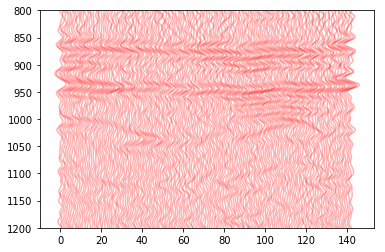

In [18]:
fig,ax = plt.subplots()
y_res_obs=np.array(d_list)/1.e5
y_res_pred=np.array(r_pred)
offsets=[i for i in range(len(d_list))]
t=np.array(list(range(798,1202,2)))
for i in range(len(offsets)):
    x_obs=offsets[i]+10*y_res_obs[i]
    x_pred=offsets[i]+50*y_res_pred[i]
    #ax.plot(x_obs,t,'k')
    ax.plot(x_pred,t,'r', alpha=0.3)
    #ax.fill_betweenx(y,offsets[i],x_obs,where=(x_obs>offsets[i]),color='k')
    #ax.fill_betweenx(y,offsets[i],x_pred,where=(x_pred>offsets[i]),color='r')
ax.set_ylim(1200,800)
plt.show()

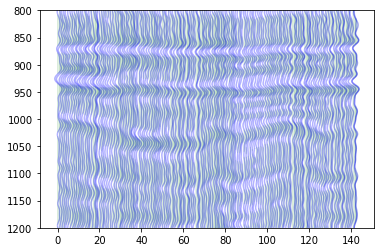

In [19]:
fig,ax = plt.subplots()

#y_res_obs=np.array(r_list)
y_res_pred=np.array(r_pred_integ)
offsets=[i for i in range(len(d_list))]
t=np.array(list(range(800,1202,2)))
for i in range(len(offsets)):
    x_obs=offsets[i]+10*y_res_obs[i]
    x_pred=offsets[i]+5*y_res_pred[i]
    #ax.plot(x_obs,y,'k')
    ax.plot(x_pred,t,'b', alpha=0.3)
    #ax.fill_betweenx(y,offsets[i],x_obs,where=(x_obs>offsets[i]),color='k')
    ax.fill_betweenx(t,offsets[i],x_pred,where=(x_pred>offsets[i]),color='g', alpha=0.1)
ax.set_ylim(1200,800)
plt.show()